<a href="https://colab.research.google.com/github/saadatialirezam-create/glaucoma-detection/blob/main/02_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from google.colab import drive

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

train = np.load("/content/drive/MyDrive/Glaucoma_data/splits/train_split.npz")
test  = np.load("/content/drive/MyDrive/Glaucoma_data/splits/test_split.npz")

X_train = train["X"]
y_train = train["y"]
X_test  = test["X"]
y_test  = test["y"]

print("Train:", X_train.shape, y_train.shape, X_train.dtype)
print("Test :", X_test.shape,  y_test.shape,  X_test.dtype)

if X_train.ndim == 3:
    X_train = X_train[..., None]
if X_test.ndim == 3:
    X_test = X_test[..., None]

Mounted at /content/drive
Train: (1898, 224, 224) (1898,) uint8
Test : (475, 224, 224) (475,) uint8


In [3]:
SEED = 19
rng = np.random.default_rng(SEED)

idx = rng.permutation(len(y_train))
X_train = X_train[idx]
y_train = y_train[idx]

val_ratio = 0.2
val_size = int(len(y_train) * val_ratio)

X_val = X_train[:val_size]
y_val = y_train[:val_size]
X_tr  = X_train[val_size:]
y_tr  = y_train[val_size:]

print("Train split:", X_tr.shape, y_tr.shape)
print("Val split  :", X_val.shape, y_val.shape)

Train split: (1519, 224, 224, 1) (1519,)
Val split  : (379, 224, 224, 1) (379,)


In [4]:
BATCH_SIZE = 32

def to_rgb_and_preprocess(x, y):
    x = tf.cast(x, tf.float32)

    x = tf.cond(tf.reduce_max(x) <= 1.0, lambda: x * 255.0, lambda: x)

    x = tf.image.grayscale_to_rgb(x)  # (224,224,3)
    x = preprocess_input(x)           # VGG16 preprocessing (caffe)
    return x, y

train_ds = tf.data.Dataset.from_tensor_slices((X_tr, y_tr)) \
    .shuffle(4096, seed=SEED) \
    .map(to_rgb_and_preprocess) \
    .batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
    .map(to_rgb_and_preprocess) \
    .batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
    .map(to_rgb_and_preprocess) \
    .batch(BATCH_SIZE)

In [5]:
base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base.trainable = False

inputs = layers.Input(shape=(224, 224, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

base.trainable = True

for layer in base.layers[:-4]:
    layer.trainable = False

print("Trainable layers in base:", sum(l.trainable for l in base.layers), "/", len(base.layers))

fine_tune_lr = 1e-5
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]
)

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 44s 624ms/step - accuracy: 0.5466 - loss: 1.1398 - precision: 0.3611 - recall: 0.3478 - val_accuracy: 0.6016 - val_loss: 0.7888 - val_precision: 0.3056 - val_recall: 0.1789 - learning_rate: 1.0000e-04
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 49s 194ms/step - accuracy: 0.5406 - loss: 1.2238 - precision: 0.3649 - recall: 0.3392 - val_accuracy: 0.6174 - val_loss: 0.7882 - val_precision: 0.3333 - val_recall: 0.1789 - learning_rate: 1.0000e-04
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.5595 - loss: 1.1145 - precision: 0.3826 - recall: 0.2857 - val_accuracy: 0.6253 - val_loss: 0.7761 - val_precision: 0.3766 - val_recall: 0.2358 - learning_rate: 1.0000e-04
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.5755 - loss: 1.1365 - precision: 0.3936 - recall: 0.3447 - val_accuracy: 0.6359 - val_loss: 0.7735 - val_precision: 0.4026 - val_recall: 0.2520 - learning_rate: 1.0000e-04
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 205

In [7]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

y_prob = model.predict(test_ds).ravel()

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 4) Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (rows=true, cols=pred):\n", cm)

tn, fp, fn, tp = cm.ravel()
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal(0)", "Glaucoma(1)"]))

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step
Confusion Matrix (rows=true, cols=pred):
 [[269  29]
 [ 82  95]]
TN=269, FP=29, FN=82, TP=95

Classification Report:
               precision    recall  f1-score   support

   Normal(0)       0.77      0.90      0.83       298
 Glaucoma(1)       0.77      0.54      0.63       177

    accuracy                           0.77       475
   macro avg       0.77      0.72      0.73       475
weighted avg       0.77      0.77      0.76       475



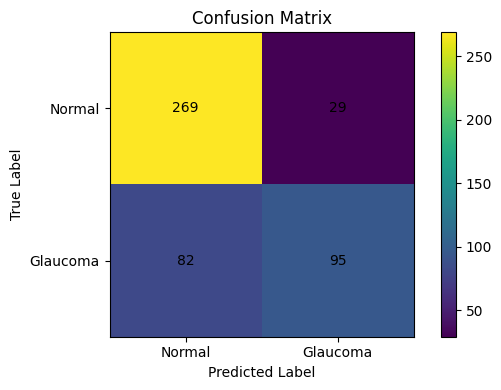

In [8]:
import matplotlib.pyplot as plt

classes = ["Normal", "Glaucoma"]

plt.figure(figsize=(6,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center", color="black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

In [ ]:
test_metrics = model.evaluate(test_ds, verbose=1)
print("Test metrics:", dict(zip(model.metrics_names, test_metrics)))

In [9]:
from pathlib import Path

SAVE_DIR = Path("/content/drive/MyDrive/Glaucoma_data_preds")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_prob = model.predict(test_ds).ravel()
y_pred = (y_prob >= 0.5).astype(np.int64)

np.save(SAVE_DIR / "y_true.npy", y_true)
np.save(SAVE_DIR / "vgg16_prob.npy", y_prob)
np.save(SAVE_DIR / "vgg16_pred.npy", y_pred)

print("Saved to:", SAVE_DIR)

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step
Saved to: /content/drive/MyDrive/Glaucoma_data_preds
